# How Convolution layer works?


- 기수: 14기

- 이름: 이건일

- 작성자: 13기 강승우

이번 문제에서는 직접 Convolution 연산을 구현해보며 CNN의 동작 원리를 알아보고자 합니다.

**목표**
- `nn.Conv2d`와 동일한 연산을 **NumPy로 직접 구현**
- laplacian filter와 sobel filter를 **이미지에 적용**

**라이브러리 및 함수 정의**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from typing import Tuple, Optional

# 시각화 유틸
def show_gray(img, title=None):
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

def minmax_norm(x: np.ndarray, eps: float = 1e-12):
    mn, mx = np.min(x), np.max(x)
    if mx - mn < eps:
        return np.zeros_like(x)
    return (x - mn) / (mx - mn)

**이미지 준비**

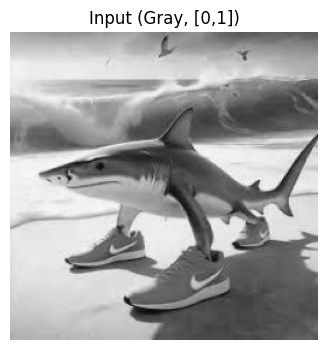

In [2]:
def load_image(path: Optional[str] = None, size: Tuple[int,int]=(256,256)) -> np.ndarray:
    img = Image.open(path).convert('L').resize(size, Image.BILINEAR)
    arr = np.array(img, dtype=np.float32) / 255.0
    return arr

# 사용 예시: path=None -> 합성 이미지
img = load_image(path="tralla.jpg", size=(256,256))
show_gray(img, title='Input (Gray, [0,1])')


**Q1. numpy를 사용하여 이미지와 커널 배열을 입력으로 받는 conv2D_naive 함수를 구현하세요**

In [3]:
def conv2d_naive(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """
    image: (H, W), float32
    kernel: (kH, kW)

    반환: (outH, outW)
    """
    
    padding = 0
    padded = np.pad(image, ((padding, padding), (padding, padding)), mode='constant')
    stride = 1

    kH, kW = kernel.shape
    
    pH, pW = padded.shape
    outH = (pH - kH) // stride + 1
    outW = (pW - kW) // stride + 1
    
    out = np.zeros((outH, outW), dtype=np.float32)
    
    for i in range(outH):
        for j in range(outW):
            patch = padded[i*stride:i*stride+kH, j*stride:j*stride+kW]
            out[i, j] = np.sum(patch * kernel)
    
    return out


**Q2. 작성한 코드의 동작 방식이 왜 CNN의 convolution 연산과 동일한지 아래에 Markdown을 추가하여 자세히 설명해주세요. (예시를 들어 설명하셔도 좋습니다)**

입력 이미지 위에 커널을 왼쪽 위에서 오른쪽 아래로 stride=1로 이동시키며 각 위치마다 커널과 이미지의 해당 패치를 곱한 뒤 모두 더해 결과값을 출력 배열에 저장한다. 이는 CNN의 Conv2d 연산에서 커널이 입력 feature map 위를 슬라이딩하며 합성곱을 계산하는 방식과 동일하다. 출력 feature map의 크기도 {(입력+패딩-커널) / stride} + 1로 계산하여, Conv2d의 출력 크기 공식과 동일하게 동작한다.

예를 들어, 5x5 이미지와 3x3 커널이 있을 때, 커널을 이미지 위에서 한 칸씩 이동시키며 각 위치마다 3x3 영역과 커널을 곱해 합산한 값을 출력에 저장한다. 이 과정은 CNN의 합성곱 연산과 일치한다.

**라플라시안 필터 적용 및 시각화**


- Laplace Filter  
\begin{bmatrix}
1 & 1 & 1\\
1 & -8 & 1\\
1 & 1 & 1
\end{bmatrix}

- Sobel Filter(수직)  
\begin{bmatrix}
-1 & 0 & 1\\
-2 & 0 & 2\\
-1 & 0 & 1
\end{bmatrix}

- Sobel Filter(수평)
\begin{bmatrix}
-1 & -2 & -1\\
0 & 0 & 0\\
1 & 2 & 1
\end{bmatrix}


In [4]:
laplace = np.array([[ 1, 1, 1],
                    [ 1,-8, 1],
                    [ 1, 1, 1]], dtype=np.float32)

sobel_vertical = np.array([[ -1, 0, 1],
                           [ -2, 0, 2],
                           [ -1, 0, 1]], dtype=np.float32)

sobel_horizontal = np.array([[ -1, -2, -1],
                             [  0,  0,  0],
                             [  1,  2,  2]], dtype=np.float32)

print('laplace:\n', laplace)
print('sobel_vertical\n', sobel_vertical)
print('sobel_horizontal:\n', sobel_horizontal)

laplace:
 [[ 1.  1.  1.]
 [ 1. -8.  1.]
 [ 1.  1.  1.]]
sobel_vertical
 [[-1.  0.  1.]
 [-2.  0.  2.]
 [-1.  0.  1.]]
sobel_horizontal:
 [[-1. -2. -1.]
 [ 0.  0.  0.]
 [ 1.  2.  2.]]


**구현한 Conv함수와 주어진 filter로 이미지의 edge를 검출해보세요**
- 결과의 범위가 음수가 될 수 있어, 시각화를 위해 정규화 사용

In [5]:
def apply_filter_and_visualize(img: np.ndarray, kernel: np.ndarray, stride: int = 1):

    resp = conv2d_naive(img, kernel)
    resp_signed = minmax_norm(resp)      # [-?, +?] -> [0,1] 정규화
    
    show_gray(img, 'Input')
    show_gray(resp_signed, 'Laplacian response (signed → min-max normalized)')
    return resp

=== Laplacian ===


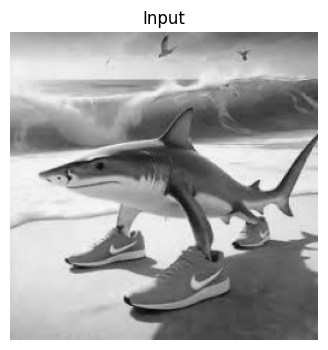

=== Sobel Vertical ===


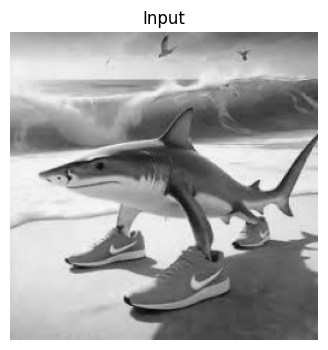

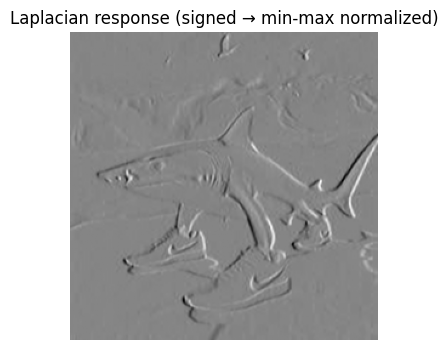

=== Sobel Horizontal ===


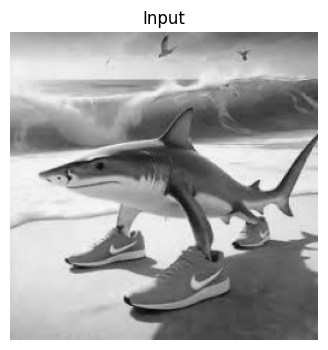

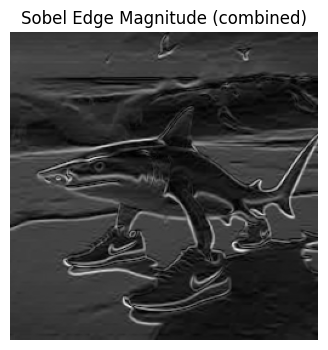

In [6]:
print('=== Laplacian ===')
resp_lp = apply_filter_and_visualize(img, laplace)

print('=== Sobel Vertical ===')
resp_sv = apply_filter_and_visualize(img, sobel_vertical)

print('=== Sobel Horizontal ===')
resp_sh = apply_filter_and_visualize(img, sobel_horizontal)

edge_mag = np.sqrt(resp_sv**2 + resp_sh**2)
edge_mag = minmax_norm(edge_mag)

show_gray(edge_mag, 'Sobel Edge Magnitude (combined)')

In [7]:
class MyConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        super().__init__()
        kH, kW = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        self.stride = stride
        self.padding = padding
        self.kH, self.kW = kH, kW
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kH, kW)*0.01)
        self.bias = nn.Parameter(torch.zeros(out_channels)) if bias else None

    def forward(self, x):
        # x: (N, C_in, H, W)
        N, C_in, H, W = x.shape
        # zero-padding (torch 연산)
        if self.padding > 0:
            x_pad = F.pad(x, (self.padding, self.padding, self.padding, self.padding))
        else:
            x_pad = x

        Hpad, Wpad = x_pad.shape[-2:]
        outH = (Hpad - self.kH)//self.stride + 1
        outW = (Wpad - self.kW)//self.stride + 1

        y = x.new_zeros((N, self.weight.shape[0], outH, outW))  # (N, C_out, outH, outW)

        # 완전 동일한 슬라이딩-패치 곱-합 (모두 torch 텐서 연산 → autograd OK)
        for n in range(N):
            for co in range(self.weight.shape[0]):
                w = self.weight[co]  # (C_in, kH, kW)
                for i in range(outH):
                    hs = i*self.stride
                    for j in range(outW):
                        ws = j*self.stride
                        patch = x_pad[n, :, hs:hs+self.kH, ws:ws+self.kW]  # (C_in, kH, kW)
                        y[n, co, i, j] = (patch * w).sum()
                if self.bias is not None:
                    y[n, co] += self.bias[co]
        return y

# Resnet18 구현하기

앞선 문제에서 Convolution 연산을 구현하여 보았으니,  
이번에는 **Resnet18을 직접 구현**해보고자 합니다.  
**Pytorch의 nn.Conv2d를 사용하시면 되지만**,  
본인이 구현한 Conv2d가 backward 연산이 가능하도록 설계되었다면 그것을 사용하여 구현하셔도 좋습니다.

**라이브러리 및 함수 정의**

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm

data_path = "./data"

batch_size = 100

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform) 
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [01:10<00:00, 2.42MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [9]:
def train(model, trainloader, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(),
        lr=0.01,
        weight_decay=5e-4,
        momentum=0.9
    )
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in tqdm(trainloader,desc=f'Epoch {epoch+1}/{epochs}'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(trainloader)}")

def test(model, testloader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

**Q1. CIFAR10 데이터셋을 분류하는 Resnet18 classifier를 구현하세요**

Input (Batch size x 3 x 32 x 32) / Output (Batch size x Num class)  
이미지 배치를 입력받아 label 개수에 맞는 logit을 반환하도록 BasicBlock과 ResNet18 class를 정의해주세요  
**ImageNet(224x224)을 입력으로 받는 Original ResNet18과 달리 CIFAR10(32x32)을 입력으로 받으므로,**  
- **conv1과 conv2 layer의 filter size와, maxpooling, stride,**  
- **fc layer의 output dimension을 적절히 변형하셔야 합니다.**

![사진](./ResNet_Architectures.png)

In [10]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1) -> None:
        super(BasicBlock, self).__init__()
        self.relu = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)

        self.residual = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = out + self.residual(x)
        out = self.relu(out)
        return out


# --- ResNet-18 for CIFAR-10 ---
class ResNet18(nn.Module):
    def __init__(self, num_classes: int = 10) -> None:
        super(ResNet18, self).__init__()
        # stem: CIFAR-10 전용 (3x3, s=1), maxpool 제거
        self.conv1   = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1     = nn.BatchNorm2d(64)
        self.relu    = nn.ReLU()
        self.maxpool = nn.Identity()  # 제거

        # stages: [2,2,2,2]
        # layer2: 64 -> 64
        self.layer2_1 = BasicBlock(64, 64, stride=1)
        self.layer2_2 = BasicBlock(64, 64, stride=1)

        # layer3: 64 -> 128 (첫 블록 stride=2)
        self.layer3_1 = BasicBlock(64, 128, stride=2)
        self.layer3_2 = BasicBlock(128, 128, stride=1)

        # layer4: 128 -> 256
        self.layer4_1 = BasicBlock(128, 256, stride=2)
        self.layer4_2 = BasicBlock(256, 256, stride=1)

        # layer5: 256 -> 512
        self.layer5_1 = BasicBlock(256, 512, stride=2)
        self.layer5_2 = BasicBlock(512, 512, stride=1)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc      = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def forward(self, x):
        # stem
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)  # Identity

        # stages
        x = self.layer2_1(x); x = self.layer2_2(x)
        x = self.layer3_1(x); x = self.layer3_2(x)
        x = self.layer4_1(x); x = self.layer4_2(x)
        x = self.layer5_1(x); x = self.layer5_2(x)

        # head
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)  # (N, 10) logits
        return x

모델이 안정적으로 학습되는지, 테스트 정확도가 잘 나오는지 (80% 이상) 확인해보세요

In [11]:
torch.manual_seed(42)
model = ResNet18().to(device)
train(model, trainloader, epochs=20)

Epoch 1/20: 100%|██████████| 500/500 [04:46<00:00,  1.75it/s]


Epoch 1/20, Loss: 1.2570065743923187


Epoch 2/20: 100%|██████████| 500/500 [05:31<00:00,  1.51it/s]


Epoch 2/20, Loss: 0.7323200596570969


Epoch 3/20: 100%|██████████| 500/500 [06:00<00:00,  1.39it/s]


Epoch 3/20, Loss: 0.5222210164666176


Epoch 4/20: 100%|██████████| 500/500 [05:24<00:00,  1.54it/s]


Epoch 4/20, Loss: 0.3811976544260979


Epoch 5/20: 100%|██████████| 500/500 [05:05<00:00,  1.64it/s]


Epoch 5/20, Loss: 0.27169410364329816


Epoch 6/20: 100%|██████████| 500/500 [05:55<00:00,  1.41it/s]


Epoch 6/20, Loss: 0.19000971190631388


Epoch 7/20: 100%|██████████| 500/500 [06:52<00:00,  1.21it/s]


Epoch 7/20, Loss: 0.1347065431587398


Epoch 8/20: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


Epoch 8/20, Loss: 0.09623682311736047


Epoch 9/20: 100%|██████████| 500/500 [06:21<00:00,  1.31it/s]


Epoch 9/20, Loss: 0.08029599675163626


Epoch 10/20: 100%|██████████| 500/500 [06:39<00:00,  1.25it/s]


Epoch 10/20, Loss: 0.051867906616069374


Epoch 11/20: 100%|██████████| 500/500 [07:27<00:00,  1.12it/s]


Epoch 11/20, Loss: 0.03546426301728934


Epoch 12/20: 100%|██████████| 500/500 [07:31<00:00,  1.11it/s]


Epoch 12/20, Loss: 0.030060806930065156


Epoch 13/20: 100%|██████████| 500/500 [07:25<00:00,  1.12it/s]


Epoch 13/20, Loss: 0.03503358406946063


Epoch 14/20: 100%|██████████| 500/500 [07:23<00:00,  1.13it/s]


Epoch 14/20, Loss: 0.03323130541294813


Epoch 15/20: 100%|██████████| 500/500 [07:18<00:00,  1.14it/s]


Epoch 15/20, Loss: 0.021855262564029546


Epoch 16/20: 100%|██████████| 500/500 [07:09<00:00,  1.16it/s]


Epoch 16/20, Loss: 0.019767831167788245


Epoch 17/20: 100%|██████████| 500/500 [06:40<00:00,  1.25it/s]


Epoch 17/20, Loss: 0.013990137977292762


Epoch 18/20: 100%|██████████| 500/500 [06:49<00:00,  1.22it/s]


Epoch 18/20, Loss: 0.011953164763282984


Epoch 19/20: 100%|██████████| 500/500 [06:30<00:00,  1.28it/s]


Epoch 19/20, Loss: 0.012752652381313965


Epoch 20/20: 100%|██████████| 500/500 [06:19<00:00,  1.32it/s]

Epoch 20/20, Loss: 0.013714299656799994


In [12]:
test(model, testloader, device)

Test Accuracy: 82.94%


82.94

**Q2. Original ResNet18과 CIFAR10 분류용으로 구현한 ResNet18의 차이점과 그렇게 수정한 이유를 아래 마크다운에 자세히 설명해주세요.**

1. 입력 이미지 크기 차이
   - Original ResNet18: ImageNet(224x224) 크기의 이미지를 입력으로 가정
   - CIFAR10 분류용 ResNet18: CIFAR10(32x32) 크기의 이미지를 입력으로 사용

2. 초기 Convolution 구조
   - Original: Conv2d(3, 64, kernel_size=7, stride=2, padding=3) + MaxPool2d(kernel_size=3, stride=2, padding=1)
   - CIFAR10 분류용: Conv2d(3, 64, kernel_size=3, stride=1, padding=1) + MaxPool 제거(nn.Identity())
   - CIFAR10 이미지는 매우 작기 때문에, 7x7 커널과 2번의 다운샘플링(stride=2, maxpool)을 적용하면 feature map이 너무 작아져 정보 손실이 크기 때문에3x3 커널, stride=1, maxpool 제거로 정보를 보존한다.

3. Fully Connected Layer 구조
   - Original: nn.Linear(512, 1000) (ImageNet 1000 클래스)
   - CIFAR10 뷴류용: nn.Linear(512, 10) (CIFAR10 10 클래스)
   - 분류해야 할 클래스 수가 다르기 때문에 출력 차원을 10으로 변경해야 한다.

4. 전체 네트워크 깊이와 블록 구조
   - 블록의 개수와 구조(2,2,2,2)는 동일하게 유지하고 각 블록의 stride, 채널 수 등도 동일하게 구현한다.

5. 다운샘플링 방식
   - 각 stage의 첫 블록에서만 stride=2로 다운샘플링한다. 이는 Original 구조와 동일하다.